# Full Modeling Refinement

In [58]:
# imports
import housing as hous
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn stuff
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer #, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score, mean_absolute_error

In [59]:
def metrics(y, preds, model):
    mse = np.round(mean_squared_error(y, preds))
    rmse = np.round(root_mean_squared_error(y, preds))
    r2 = np.round(r2_score(y, preds),5)
    mae = np.round(mean_absolute_error(y, preds))
    print(f"Mean squared error: {mse}\n")
    print(f"Root mean squared error: {rmse}\n")
    print(f"R2 score: {r2}\n")
    print(f"Mean absolute error: {mae}\n")

    return pd.DataFrame([{'model': model, 'mean_sq_err': mse, 'root_mean_sq_err': rmse, 'r2': r2, 'mean_abs_err': mae}])

## Data Preparation

In [3]:
data = pd.read_csv('../data/train_ord_encode.csv')

data.head()

,id,pid,ms_subclass,ms_zoning,lot_area,alley,land_contour,lot_config,neighborhood,bldg_type,...,exter_cond_ord,bsmt_cond_ord,bsmt_exposure_ord,heating_qc_ord,electrical_ord,kitchen_qual_ord,functional_ord,garage_qual_ord,garage_cond_ord,paved_drive_ord
0,109,533352170,60,RL,13517,no,Lvl,CulDSac,Sawyer,1Fam,...,3,3,1,5,5,4,8,3,3,3
1,544,531379050,60,RL,11492,no,Lvl,CulDSac,SawyerW,1Fam,...,3,3,1,5,5,4,8,3,3,3
2,153,535304180,20,RL,7922,no,Lvl,Inside,NAmes,1Fam,...,4,3,1,3,5,4,8,3,3,3
3,318,916386060,60,RL,9802,no,Lvl,Inside,Timber,1Fam,...,3,3,1,4,5,3,8,3,3,3
4,255,906425045,50,RL,14235,no,Lvl,Inside,SawyerW,1Fam,...,3,4,1,3,5,3,8,3,3,1


In [4]:
data = data[data['saleprice']<500_000]

In [5]:
data_test= pd.read_csv('../data/test_ord_encode.csv')

In [6]:
def has_misc_feat(row):
    if row['misc_feature'] == 'no':
        return 0
    else:
        return 1

data['has_misc_feature'] = data.apply(lambda row: has_misc_feat(row), axis=1)
data_test['has_misc_feature'] = data_test.apply(lambda row: has_misc_feat(row), axis=1)

In [7]:
feat_ss = [
    'overall_qual', 'gr_liv_area', 'overall_cond', 'garage_area', 'lot_area', 'bedroom_abvgr'
]

feat_ohe = [
    'neighborhood',  'land_contour', 'bldg_type'
]


feat_encoded = [
    'is_rr_near', 'is_rr_adj', 'is_pos_near', 'is_pos_adj', 'has_misc_feature',
    'ext_vinyl', 'ext_metal', 'ext_hardboard', 'ext_wood_side', 'ext_plywood', 'ext_cement_bd', 
    'ext_brick_face', 'ext_wood_shingle', 'ext_asbestos_shingle', 'ext_stucco'
]

## Model Creations

In [8]:
X= data[feat_ss + feat_ohe + feat_encoded]
y= data['saleprice']

X.shape, y.shape

((2036, 24), (2036,))

In [9]:
X_test = data_test[feat_ss + feat_ohe + feat_encoded]
X_test.shape

(878, 24)

In [10]:
X_train, X_val, y_train, y_val= train_test_split(X, y)

In [11]:
ct= ColumnTransformer([
    ('ss', StandardScaler(), feat_ss),
    ('ohe', OneHotEncoder(min_frequency= 0.007, handle_unknown= 'infrequent_if_exist'), feat_ohe)
], remainder='passthrough', force_int_remainder_cols=False)

## Linear Model

In [12]:
pipe_linear = Pipeline(
    [
        ('ct', ct),
        ('lr', LinearRegression())
    ]
)

pipe_linear.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ss', StandardScaler(),
                                                  ['overall_qual',
                                                   'gr_liv_area',
                                                   'overall_cond',
                                                   'garage_area', 'lot_area',
                                                   'bedroom_abvgr']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=0.007),
                                                  ['neighborhood',
                                                   'land_contour',
                                                   'bldg_type'])])),
                ('lr', LinearRegression())])

In [13]:
pipe_linear.score(X_val, y_val)

0.8539714084511777

In [14]:
prices = pd.DataFrame(pipe_linear.predict(X_test), columns=['saleprice'])

In [15]:
kaggle_linear = pd.merge(data_test, prices, left_index=True, right_index=True, how='inner')

In [16]:
kaggle_linear[['id', 'saleprice']].to_csv('../data/kaggle_linear_02.csv', index=False)

In [60]:
linear_scores = metrics(y_val, pipe_linear.predict(X_val), 'linear')

Mean squared error: 681360210.0

Root mean squared error: 26103.0

R2 score: 0.85397

Mean absolute error: 19336.0



## Ridge Models

In [17]:
pipe_ridge = Pipeline(
    [
        ('ct', ct),
        ('ridge', Ridge())
    ]
)

pipe_ridge.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ss', StandardScaler(),
                                                  ['overall_qual',
                                                   'gr_liv_area',
                                                   'overall_cond',
                                                   'garage_area', 'lot_area',
                                                   'bedroom_abvgr']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=0.007),
                                                  ['neighborhood',
                                                   'land_contour',
                                                   'bldg_type'])])),
                ('ridge', Ridge())])

In [19]:
ridge_params = {
    'ridge__alpha': np.logspace(-10,1,100)
}

In [20]:
gs_ridge = GridSearchCV(
    pipe_ridge,
    ridge_params,
    cv=5
)

gs_ridge.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('ss',
                                                                         StandardScaler(),
                                                                         ['overall_qual',
                                                                          'gr_liv_area',
                                                                          'overall_cond',
                                                                          'garage_area',
                                                                          'lot_area',
                                                                          'bedroom_abvgr']),
                                                                        ('ohe',
                                                                         OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                       min_frequency=0.007),
                                                                         ['neighborhood',
                                                                          'land_c...
       2.78255940e-02, 3.59381366e-02, 4.64158883e-02, 5.99484250e-02,
       7.74263683e-02, 1.00000000e-01, 1.29154967e-01, 1.66810054e-01,
       2.15443469e-01, 2.78255940e-01, 3.59381366e-01, 4.64158883e-01,
       5.99484250e-01, 7.74263683e-01, 1.00000000e+00, 1.29154967e+00,
       1.66810054e+00, 2.15443469e+00, 2.78255940e+00, 3.59381366e+00,
       4.64158883e+00, 5.99484250e+00, 7.74263683e+00, 1.00000000e+01])})

In [21]:
gs_ridge.best_params_

{'ridge__alpha': 2.782559402207126}

In [22]:
gs_ridge.score(X_val, y_val)

0.8543548444842881

In [23]:
prices = pd.DataFrame(gs_ridge.predict(X_test), columns=['saleprice'])

In [24]:
kaggle_ridge = pd.merge(data_test, prices, left_index=True, right_index=True, how='inner')

In [25]:
kaggle_ridge[['id', 'saleprice']].to_csv('../data/kaggle_ridge_01.csv', index=False)

In [61]:
ridge_scores = metrics(y_val, pipe_ridge.predict(X_val), 'ridge')

Mean squared error: 679987352.0

Root mean squared error: 26077.0

R2 score: 0.85427

Mean absolute error: 19310.0



In [79]:
scores = pd.concat([linear_scores, ridge_scores], ignore_index=True)

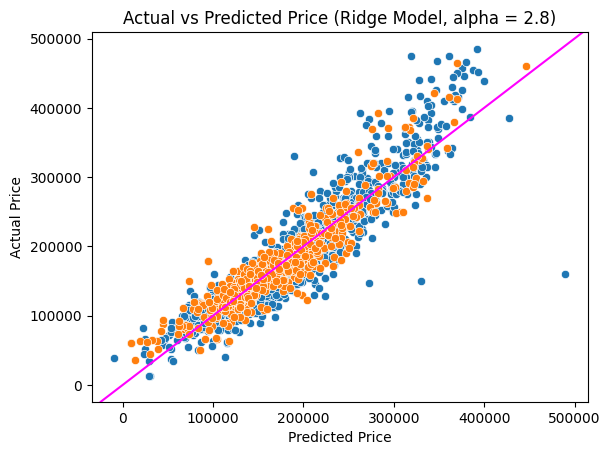

In [88]:
fig, ax = plt.subplots()

sns.scatterplot(x = gs_ridge.predict(X_train), y= y_train)
sns.scatterplot(x = gs_ridge.predict(X_val), y = y_val)

ax.axline(xy1=(0,0), slope=1, color='magenta')
ax.set_title('Actual vs Predicted Price (Ridge Model, alpha = 2.8)')
ax.set_xlabel('Predicted Price')
ax.set_ylabel('Actual Price');

plt.savefig('../images/ridge_val_data.jpg')

## KNN Models

In [26]:
pipe_knn = Pipeline(
    [
        ('ct', ct),
        ('knn', KNeighborsRegressor())
    ]
)

pipe_knn.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ss', StandardScaler(),
                                                  ['overall_qual',
                                                   'gr_liv_area',
                                                   'overall_cond',
                                                   'garage_area', 'lot_area',
                                                   'bedroom_abvgr']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=0.007),
                                                  ['neighborhood',
                                                   'land_contour',
                                                   'bldg_type'])])),
                ('knn', KNeighborsRegressor())])

In [27]:
knn_params = {
    'knn__p': [1,2],
    'knn__weights': ['uniform', 'distance'],
    'knn__n_neighbors': [3,5,7,11,15, 25, 40]
}

In [28]:
gs_knn = GridSearchCV(
    pipe_knn,
    knn_params,
    n_jobs=-1
)

In [29]:
gs_knn.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('ss',
                                                                         StandardScaler(),
                                                                         ['overall_qual',
                                                                          'gr_liv_area',
                                                                          'overall_cond',
                                                                          'garage_area',
                                                                          'lot_area',
                                                                          'bedroom_abvgr']),
                                                                        ('ohe',
                                                                         OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                       min_frequency=0.007),
                                                                         ['neighborhood',
                                                                          'land_contour',
                                                                          'bldg_type'])])),
                                       ('knn', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [3, 5, 7, 11, 15, 25, 40],
                         'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance']})

In [30]:
gs_knn.score(X_val, y_val)

0.8349378251429272

In [31]:
gs_knn.best_params_

{'knn__n_neighbors': 7, 'knn__p': 2, 'knn__weights': 'distance'}

In [32]:
prices_knn = pd.DataFrame(gs_knn.predict(X_test), columns=['saleprice'])

In [33]:
kaggle_knn = pd.merge(data_test, prices_knn, left_index=True, right_index=True, how='inner')

In [34]:
kaggle_knn[['id', 'saleprice']].to_csv('../data/kaggle_knn_03.csv', index=False)

In [80]:
knn_scores = metrics(y_val, pipe_knn.predict(X_val), 'knn')

Mean squared error: 788293374.0

Root mean squared error: 28077.0

R2 score: 0.83105

Mean absolute error: 19446.0



In [81]:
scores = pd.concat([scores, knn_scores], ignore_index=True)

## Tree Models

In [35]:
pipe_tree = Pipeline(
    [
        ('ct', ct),
        ('tree', DecisionTreeRegressor(max_depth=5, min_samples_leaf=3))
    ]
)

In [36]:
pipe_tree.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ss', StandardScaler(),
                                                  ['overall_qual',
                                                   'gr_liv_area',
                                                   'overall_cond',
                                                   'garage_area', 'lot_area',
                                                   'bedroom_abvgr']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=0.007),
                                                  ['neighborhood',
                                                   'land_contour',
                                                   'bldg_type'])])),
                ('tree',
                 DecisionTreeRegressor(max_depth=5, min_samples_leaf=3))])

In [37]:
gs_tree = GridSearchCV(
    pipe_tree,
    {
        'tree__max_depth': [6,7, 8,9,10,11,12,15],
        'tree__min_samples_leaf': [5,8,9,12,15, 18]
    },
    cv=5,
    n_jobs=-1
)

In [38]:
gs_tree.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('ss',
                                                                         StandardScaler(),
                                                                         ['overall_qual',
                                                                          'gr_liv_area',
                                                                          'overall_cond',
                                                                          'garage_area',
                                                                          'lot_area',
                                                                          'bedroom_abvgr']),
                                                                        ('ohe',
                                                                         OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                       min_frequency=0.007),
                                                                         ['neighborhood',
                                                                          'land_contour',
                                                                          'bldg_type'])])),
                                       ('tree',
                                        DecisionTreeRegressor(max_depth=5,
                                                              min_samples_leaf=3))]),
             n_jobs=-1,
             param_grid={'tree__max_depth': [6, 7, 8, 9, 10, 11, 12, 15],
                         'tree__min_samples_leaf': [5, 8, 9, 12, 15, 18]})

In [39]:
gs_tree.best_params_

{'tree__max_depth': 11, 'tree__min_samples_leaf': 18}

In [40]:
gs_tree.score(X_val,y_val)

0.7835736572936199

In [41]:
prices_tree = pd.DataFrame(gs_tree.predict(X_test), columns= ['saleprice'])

In [42]:
kaggle_tree = pd.merge(data_test, prices_tree, left_index=True, right_index=True, how='inner')

In [43]:
kaggle_tree[['id', 'saleprice']].to_csv('../data/kaggle_tree_02.csv', index=False)

In [82]:
tree_scores = metrics(y_val, pipe_tree.predict(X_val), 'tree')

Mean squared error: 1231899060.0

Root mean squared error: 35098.0

R2 score: 0.73598

Mean absolute error: 24795.0



In [83]:
scores = pd.concat([scores, tree_scores], ignore_index=True)

### Bagging Regressor

In [44]:
bag = BaggingRegressor(
    estimator= DecisionTreeRegressor(),
    n_estimators = 100,
    max_features = 20,
    bootstrap= True,
    n_jobs=-1
)

In [45]:
pipe_bag = Pipeline([
    ('ct', ct),
    ('bag', BaggingRegressor())
])

In [46]:
pipe_bag.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ss', StandardScaler(),
                                                  ['overall_qual',
                                                   'gr_liv_area',
                                                   'overall_cond',
                                                   'garage_area', 'lot_area',
                                                   'bedroom_abvgr']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=0.007),
                                                  ['neighborhood',
                                                   'land_contour',
                                                   'bldg_type'])])),
                ('bag', BaggingRegressor())])

In [48]:
bag_params= {
    'bag__bootstrap_features': [True, False],
    'bag__max_features': [0.8, 1],
    'bag__max_samples': [0.8,0.9],
    'bag__n_estimators': [100, 200],
    'bag__warm_start': [True, False]
}

In [49]:
gs_bag = GridSearchCV(
    pipe_bag,
    bag_params,
    cv=5,
    n_jobs=-1
)

In [50]:
gs_bag.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('ss',
                                                                         StandardScaler(),
                                                                         ['overall_qual',
                                                                          'gr_liv_area',
                                                                          'overall_cond',
                                                                          'garage_area',
                                                                          'lot_area',
                                                                          'bedroom_abvgr']),
                                                                        ('ohe',
                                                                         OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                       min_frequency=0.007),
                                                                         ['neighborhood',
                                                                          'land_contour',
                                                                          'bldg_type'])])),
                                       ('bag', BaggingRegressor())]),
             n_jobs=-1,
             param_grid={'bag__bootstrap_features': [True, False],
                         'bag__max_features': [0.8, 1],
                         'bag__max_samples': [0.8, 0.9],
                         'bag__n_estimators': [100, 200],
                         'bag__warm_start': [True, False]})

In [51]:
gs_bag.score(X_train, y_train)

0.9753531984546132

In [52]:
gs_bag.score(X_val, y_val)

0.8603102693415431

In [53]:
gs_bag.best_params_

{'bag__bootstrap_features': False,
 'bag__max_features': 0.8,
 'bag__max_samples': 0.9,
 'bag__n_estimators': 100,
 'bag__warm_start': True}

In [54]:
prices_bag = pd.DataFrame(gs_bag.predict(X_test), columns= ['saleprice'])
kaggle_bag = pd.merge(data_test, prices_bag, left_index=True, right_index=True, how='inner')
kaggle_bag[['id', 'saleprice']].to_csv('../data/kaggle_bag_01.csv', index=False)

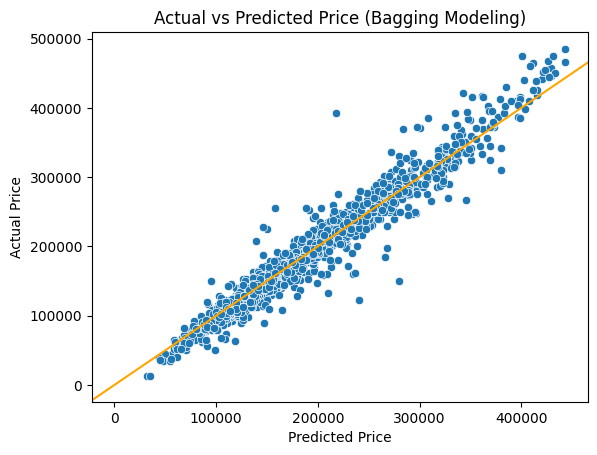

In [55]:
fig, ax = plt.subplots()

sns.scatterplot(x = gs_bag.predict(X), y = data['saleprice'])

ax.axline(xy1=(0,0), slope=1, color='orange')
ax.set_title('Actual vs Predicted Price (Bagging Modeling)')
ax.set_xlabel('Predicted Price')
ax.set_ylabel('Actual Price');

plt.savefig('../images/bagging.jpg')

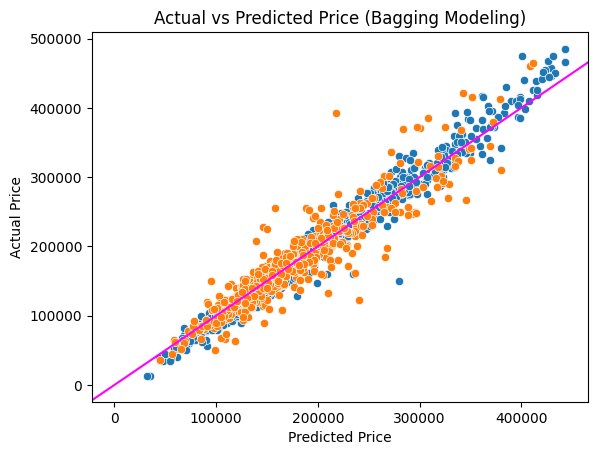

In [56]:
fig, ax = plt.subplots()

sns.scatterplot(x = gs_bag.predict(X_train), y= y_train)
sns.scatterplot(x = gs_bag.predict(X_val), y = y_val)

ax.axline(xy1=(0,0), slope=1, color='magenta')
ax.set_title('Actual vs Predicted Price (Bagging Modeling)')
ax.set_xlabel('Predicted Price')
ax.set_ylabel('Actual Price');

plt.savefig('../images/bagging_val_data.jpg')

In [84]:
bag_scores = metrics(y_val, pipe_tree.predict(X_val), 'bag')

Mean squared error: 1231899060.0

Root mean squared error: 35098.0

R2 score: 0.73598

Mean absolute error: 24795.0



In [85]:
scores = pd.concat([scores, bag_scores], ignore_index=True)

In [86]:
scores

,model,mean_sq_err,root_mean_sq_err,r2,mean_abs_err
0,linear,6.813602e+08,26103.0,0.85397,19336.0
1,ridge,6.799874e+08,26077.0,0.85427,19310.0
2,knn,7.882934e+08,28077.0,0.83105,19446.0
3,tree,1.231899e+09,35098.0,0.73598,24795.0
4,bag,1.231899e+09,35098.0,0.73598,24795.0


Interestingly, the linear and ridge have improved since the first round, while the tree and bagging models have actually gotten worse.  I hadn't realized the high variance tendency of decision trees and bagging were quite so strong!  But it really takes a solid comparison to find out.  

## Summary

Moving forward, I recommend focusing on the linear and ridge methods and continue to refine the model by varying the features until an optimal value has been reached.  

I would keep the knn and tree models, but would definitely drop the bagging since it does not improve on the decision tree regressor in this case, takes longer to run, and is a more complex model (which is clearly not needed).